# Bayes or Spam? – Spam Filtering with Bayesian Epistemology

This is an analysis of Bayesian spam filtering from the viewpoint of Bayesian epistemology. I'll review the Bayesian spam filtering algorithm, point out where it deviates from the principles of Bayesian epistemology, and present test results showing that the "principled" Bayesian spam filtering is also more effective. Finally, I'll compare Bayesian filtering to neural networks, with mixed results.

Bayesian spam filtering is one of the leading technologies of tackling spam. In his 2002 essay, [*A Plan for Spam*](http://paulgraham.com/spam.html), Paul Graham described the first effective Bayesian spam filtering algorithm. Today's Bayesian spam filters use essentially the same algorithm.

Graham's motivation was that his earlier spam filters looking for individual spam features (e.g. does it contain `"click"`?) were not effective enough. As he writes, Bayesian spam filters recognized more features, e.g. `"ff0000"` (red's hexa code used in HTML).

## Preparing the test dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import itertools
import re
import string

We're going to use the [Enron spam dataset collection](http://www2.aueb.gr/users/ion/data/enron-spam/index.html)'s `Enron1` dataset:

In [2]:
ds_url = 'http://www.aueb.gr/users/ion/data/enron-spam/preprocessed/enron1.tar.gz'
ds_path = tf.keras.utils.get_file(origin=ds_url, untar=True)

In [3]:
seed = 42
ds_base_kwargs = dict(directory=ds_path, seed=seed, validation_split=0.1)
ds_train = tf.keras.utils.text_dataset_from_directory(**ds_base_kwargs, 
                                                      subset='training')

for i, label in enumerate(ds_train.class_names):
  print(f'{i}: {label}')
for text, label in ds_train.unbatch().take(5).concatenate(
                   ds_train.unbatch().filter(lambda _, l: l == 1).take(5)):
  print(text.numpy())
  print(label.numpy())

Found 5172 files belonging to 2 classes.
Using 4655 files for training.
0: ham
1: spam
b'Subject: meter variances - ua 4 clean - up\r\ndaren / vance -\r\nthe two meters below are new and have unallocatable flow . . . . . . . i will need a\r\npurchase for each of them . please respond with a deal number , or further\r\nsuggestions for resolution so that i can clear this up as soon as possible .\r\nmary\r\nenron on 09 / 19 / 2000 08 : 44 am - - - - - - - - - - - - - - - - - - - - - - - - - - -\r\nkatherine benedict @ ect\r\n09 / 18 / 2000 04 : 53 pm\r\nto : mary poorman / na / enron @ enron , fred boas / hou / ect @ ect , aimee\r\nlannou / hou / ect @ ect\r\ncc :\r\nsubject : meter variances - ua 4 clean - up\r\nhi guys ,\r\nplease take a look at the following meters which are showing up with\r\nvariances on my ua 4 report . once the variance has been cleared , please send\r\nme an e - mail . please try to clear these within the next couple of days .\r\nthanks ,\r\nkathy benedict\r\nmete

In [4]:
len_subj = len('Subject: ')

def clean(text):
    return text[len_subj:]

print(clean('Subject: enron hello'))

enron hello


## Graham's algorithm

Here's an implementation of Graham's algorithm using Python and the TensorFlow machine learning package:

Graham used a simple tokenization he came up with, but he admits that it can improved. Let's use TensorFlow's `tf.keras.preprocessing.text.text_to_word_sequence`:

In [5]:
encoding = 'latin_1'

def tokenize(text):
    return tf.keras.preprocessing.text.text_to_word_sequence(
        clean(text.decode(encoding)), 
        filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~\t\n\r'  # Default + '\r'
        )

for text, _ in ds_train.unbatch().take(5):
  text_np = text.numpy()
  print(text_np)
  print(tokenize(text_np))

b'Subject: eastrans nomination change effective 9 / 8 / 00\r\nplease decrease deliveries to eastrans to 0 mmbtu / dy for 9 / 8 / 00\r\nthe redeliveries will be 0 as well .\r\nthe over - delivery quantity for the fuels cotton valley gas will be valued per\r\nparagraph 3 of the contract price ( per mmbtu ) section in the transaction\r\nagreement .'
['eastrans', 'nomination', 'change', 'effective', '9', '8', '00', 'please', 'decrease', 'deliveries', 'to', 'eastrans', 'to', '0', 'mmbtu', 'dy', 'for', '9', '8', '00', 'the', 'redeliveries', 'will', 'be', '0', 'as', 'well', 'the', 'over', 'delivery', 'quantity', 'for', 'the', 'fuels', 'cotton', 'valley', 'gas', 'will', 'be', 'valued', 'per', 'paragraph', '3', 'of', 'the', 'contract', 'price', 'per', 'mmbtu', 'section', 'in', 'the', 'transaction', 'agreement']
b'Subject: eastrans nomination effective 5 / 1 / 01\r\neffective 5 / 1 / 01 , the deliveries and redeliveries will be 0 mmbtu / dy .\r\nthe transaction agreement will not be utilized .'


Now let's count the spam and ham occurrences of each word:

In [6]:
good = {}
bad = {}
for text_batch, label_batch in ds_train:
  for i in range(len(text_batch)):
    text = text_batch.numpy()[i]
    label = label_batch.numpy()[i]
    for token in tokenize(text):
      good_or_bad = bad if label == 1 else good
      good_or_bad.setdefault(token, 0)
      good_or_bad[token] += 1

In [7]:
def dslice(dictionary, stop):
  return dict(itertools.islice(dictionary.items(), stop))

def dvsorted(dictionary, reverse):
  return dict(sorted(dictionary.items(), key=lambda i: i[1], reverse=reverse))

print(dslice(dvsorted(good, reverse=True), 25))
print(dslice(dvsorted(bad, reverse=True), 25))

{'the': 16460, 'to': 13750, 'ect': 12624, 'for': 7254, 'and': 7118, 'hou': 6627, 'enron': 6028, 'on': 5474, 'a': 5473, "'": 5357, 'of': 5057, 'you': 4874, 'i': 4773, 'this': 4444, 'is': 4409, 'in': 4060, '2000': 3981, 'be': 3407, 'will': 3125, 'that': 3064, 'from': 2914, 'have': 2895, 'we': 2863, 'at': 2677, 'gas': 2593}
{'the': 6584, 'to': 4650, 'and': 4402, 'of': 4087, 'a': 3427, 'in': 2802, 'you': 2471, 'for': 2293, 'this': 2044, 'is': 2033, 'your': 1761, "'": 1579, 'with': 1339, 's': 1210, 'that': 1208, 'be': 1190, 'or': 1177, 'on': 1130, 'as': 1087, 'are': 1025, 'we': 994, 'i': 981, 'it': 948, 'not': 947, 'our': 945}


The next step is to determine the word probabilities. Graham uses a complicated formula for that, which can be simplified using the fact that the number of spam and ham emails is the same for him. Additionally removing the edge-case handlings, we arrive at the standard relative frequency formula:

$$\frac{b / n_b}{g / n_g + b / n_b} \underset{n_g = n_b}{=} \frac{b}{g + b} = \frac{\mathbb{P}(\textrm{spam} \land \textrm{word})}{\mathbb{P}(\textrm{word})} = \mathbb{P}(\textrm{spam} \mid \textrm{word}).$$

Graham also added a bias: he double counted the non-spam occurrences. As he wrote, this reduced the number of false positive for him (he used his own mailbox for testing).

In [8]:
word_probs_graham = {}
for word in {**good, **bad}.keys():
  if word in word_probs_graham:
    continue
  g = 2 * good.get(word, 0)  # Here's the bias
  b = bad.get(word, 0)
  word_probs_graham[word] = b / (g + b)

In [9]:
print(dslice(word_probs_graham, 10))

{'txu': 0.0, 'fuels': 0.0029850746268656717, 'sds': 0.0, 'nomination': 0.0009319664492078285, 'for': 0.13647997143027202, 'january': 0.08254397834912043, '2001': 0.001091703056768559, 'attached': 0.006602336211274758, 'is': 0.1873560040549258, 'the': 0.16666666666666666}


For a word which was never seen before, he sets $0.4$ probability. ("\[I\]t is probably fairly innocent; spam words tend to be all too familiar.")

In [10]:
def get_word_prob(word, word_probs):
  return word_probs.get(word, 0.4)

print(get_word_prob('enron', word_probs_graham))
print(get_word_prob('company', word_probs_graham))
print('neverseen' not in word_probs_graham)
print(get_word_prob('neverseen', word_probs_graham))

0.0
0.44625407166123776
True
0.4


The probability of independent events' intersection can be calculated from the individual events' probabilities $p_1, \dots , p_n$ as

$$\frac{\prod_{i=1}^n p_i}{\prod_{i=1}^n p_i \prod_{i=1}^n (1 - p_i)}.$$

In [11]:
def combine(probs):
    prod = np.prod(probs)
    neg_prod = np.prod([1 - p for p in probs])
    return prod / (prod + neg_prod)

print(combine([0.6, 0.72]))

0.7941176470588235


The spam probability of an email is calculated based on the most interesting fifteen words in it, where interestingness is defined by how far they are from $0.5$:

In [12]:
def get_interesting_probs(probs):
  return sorted(probs, 
                key=lambda p: abs(p - 0.5),
                reverse=True)[:15]

print(get_interesting_probs([0.001, 0.002, 0.003, 0.004, 0.005,
                             0.91, 0.92, 0.93, 0.94, 0.95,
                             0.006, 0.007, 0.008, 0.009, 0.01,
                             0.4, 0.5, 0.6]))

[0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.95, 0.94, 0.93, 0.92, 0.91]


In [13]:
def get_text_prob(text, word_probs):
  words = tokenize(text)
  probs = [get_word_prob(w, word_probs) for w in words]
  interesting_probs = get_interesting_probs(probs)
  return combine(interesting_probs)

print(get_text_prob(b'Subject: sex', word_probs_graham))
print(get_text_prob(b'Subject: Enron', word_probs_graham))

0.974025974025974
0.0


An email is predicted to be spam above $0.9$ probability.

In [14]:
prob_threshold = 0.9

def predict_label(text, word_probs):
  return 1 if get_text_prob(text, word_probs) > prob_threshold else 0

print(predict_label(b'Subject: sex', word_probs_graham))
print(predict_label(b'Subject: Enron', word_probs_graham))

1
0


Now let's set up our test dataset, and evaluate Graham's spam filter.

In [15]:
ds_test = tf.keras.utils.text_dataset_from_directory(**ds_base_kwargs,
                                                     subset='validation')

for text, label in ds_test.unbatch().take(10):
  print(text.numpy())
  print(label.numpy())

Found 5172 files belonging to 2 classes.
Using 517 files for validation.
b'Subject: cdnow shipment confirmation\r\ndear daren ,\r\nthank you for shopping at cdnow . please keep this email invoice for\r\nyour records .\r\non april 3 we shipped your order number 17817331 for the following item :\r\nrobert earl keen : walking distance\r\nformat : cd quantity : 1 price : 12 . 99\r\nto the following address via u . s . postal service :\r\ndaren farmer\r\n5519 clarkston ln\r\nspring , tx 77379\r\ntotal number of items : 1\r\nsubtotal : $ 12 . 99\r\nshipping : $ 2 . 99\r\nsales tax : $ 0 . 00\r\n- - - - - - - - - -\r\nshipment total : $ 15 . 98\r\nyour order was billed to daren farmer . this shipment completes your\r\norder and is paid in full .\r\nmost orders arrive within 4 - 8 business days . however , in rare instances\r\nit may take up to 2 weeks .\r\nfor complete information about your order ( number 17817331 ) or to\r\nconfirm the status , click or copy / paste this link into your web 

In [16]:
def evaluate(prediction, label):
  if prediction == 1 and label == 1:
    return 'true_positive'
  elif prediction == 0 and label == 0:
    return 'true_negative'
  elif prediction == 1:
    return 'false_positive'
  else:
    return 'false_negative'

print(evaluate(1, 1))
print(evaluate(0, 0))
print(evaluate(1, 0))
print(evaluate(0, 1))

true_positive
true_negative
false_positive
false_negative


In [17]:
def predict_and_evaluate(tf_text, tf_label, word_probs):
  return evaluate(predict_label(tf_text.numpy(), word_probs), tf_label.numpy())

results_graham = {'true_positives': 0,
                  'true_negatives': 0,
                  'false_positives': 0,
                  'false_negatives': 0}
for t, l in ds_test.unbatch():
  results_graham[f'{predict_and_evaluate(t, l, word_probs_graham)}s'] += 1

print(results_graham)

{'true_positives': 80, 'true_negatives': 369, 'false_positives': 0, 'false_negatives': 68}


<ipython-input-11-8ae51d5e158b>:4: RuntimeWarning: invalid value encountered in double_scalars
  return prod / (prod + neg_prod)


## Correcting Graham's bias

The bias of double counting the non-spam occurrences doesn't seem to fit in to the Bayesian epistemilogical framework, which might refer to relative frequencies, but hardly to biased ones. Let's visualize the bias, and see if we can perhaps get rid of it.

One can verify that the formula for the bias is $\frac{p}{2 - p}$ by substituting $p = \frac{b}{g + b}$:

$$
\frac{\frac{b}{g + b}}{2 - \frac{b}{g + b}} = \frac{b}{2g + b}.
$$

In [18]:
def bias(p):
    return p / (2 - p)

Here's a plot comparing Graham's biased probablities to the original ones:

In [19]:
black_or_white = 'lightgrey'
mpl.rcParams['text.color'] = black_or_white
mpl.rc('axes', facecolor='none', edgecolor=black_or_white)
mpl.rcParams['xtick.color'] = black_or_white
mpl.rcParams['ytick.color'] = black_or_white
mpl.rcParams['axes.labelcolor'] = black_or_white

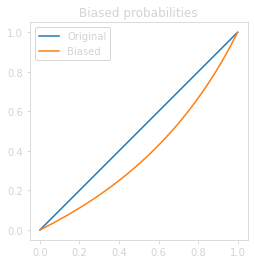

In [20]:
x = np.linspace(0, 1, 100)
plt.plot(x, x, label='Original')
plt.plot(x, bias(x), label='Biased')
plt.title('Biased probabilities')
plt.legend()
plt.gca().set_aspect('equal')

That is, Graham slightly decreased all probability values. One's intuition could be that this, instead of decreasing the number of false positives, will in fact increase the number of false negatives: for example, if a spam email consists of high-probability words which combined gives it a probability slightly above $0.9$, then with the bias we might get slightly under $0.9$, causing the email to just slip through the spam filter. Let's see if the `Enron1` dataset confirms our intuition.

By a substitution similar to the above one, the reverse formula is $\frac{2p}{p + 1}$.

In [21]:
def unbias(p):
    return (2 * p) / (p + 1)

In [22]:
word_probs_bayes = {w: unbias(p) for (w, p) in word_probs_graham.items()}

results_bayes = {'true_positives': 0,
                 'true_negatives': 0,
                 'false_positives': 0,
                 'false_negatives': 0}
for t, l in ds_test.unbatch():
  results_bayes[f'{predict_and_evaluate(t, l, word_probs_bayes)}s'] += 1

print(results_bayes)

{'true_positives': 81, 'true_negatives': 369, 'false_positives': 0, 'false_negatives': 67}


<ipython-input-11-8ae51d5e158b>:4: RuntimeWarning: invalid value encountered in double_scalars
  return prod / (prod + neg_prod)


So there's one single email on which the unbiased Bayesian filter performed better. Let's check it:

In [23]:
for email, label in ds_test.unbatch():
    email_byes = email.numpy()
    label_int = label.numpy()
    if label_int == 1 and predict_label(email_byes, word_probs_graham) != predict_label(email_byes, word_probs_bayes):
        email_str = email_byes.decode(encoding)
        print(email_str)
        print(f'Label: {label_int}')
        words = tokenize(email_byes)
        prob_graham = get_text_prob(email_byes, word_probs_graham)
        prob_bayes = get_text_prob(email_byes, word_probs_bayes)
        probs_graham = [get_word_prob(w, word_probs_graham) for w in words]
        probs_bayes = [get_word_prob(w, word_probs_bayes) for w in words]
        print(f'Graham: {prob_graham} {probs_graham}')
        print(f'Bayes: {prob_bayes} {probs_bayes}')

Subject: stop the aging clock
nerissa

Label: 1
Graham: 0.8514251061249243 [0.5950413223140496, 0.16666666666666666, 0.8181818181818182, 0.8666666666666667, 0.4]
Bayes: 0.9892113259060286 [0.7461139896373057, 0.2857142857142857, 0.9, 0.9285714285714286, 0.4]


<ipython-input-11-8ae51d5e158b>:4: RuntimeWarning: invalid value encountered in double_scalars
  return prod / (prod + neg_prod)


In [24]:
print('nerissa' not in word_probs_graham)

True


It really contains a relatively high number of spammy words ("aging" and "clock", 2 out of 5), which got overly reduced in probability by the grahamian bias, and the email eventually slipped through Graham's filter.

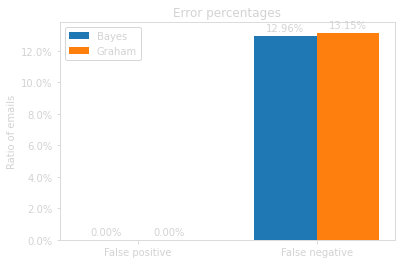

In [25]:
len_test = sum(results_graham.values())

def plot_results(results, bar_labels):
  labels = ['false_positives', 'false_negatives']
  labels_display = ['False positive', 'False negative']

  def get_y(res):
    return [res[l] / len_test * 100 for l in labels]

  x = np.arange(len(labels))
  width_sum = 0.7
  width = width_sum / len(results)  # 0.35
  fig, ax = plt.subplots()
  rects = [ax.bar(x - width_sum / 2 + width / 2 + i * width, get_y(res), width, label=lab) for i, (res, lab) in enumerate(zip(results, bar_labels))]
      
  ax.set_ylabel('Ratio of emails')
  ax.set_title('Error percentages')
  ax.set_xticks(x)
  ax.set_xticklabels(labels_display)
  ax.legend()
  for rec in rects:
    ax.bar_label(rec, fmt='%.2f%%', padding=3)
  ax.yaxis.set_major_formatter(mtick.PercentFormatter())
    
plot_results([results_bayes, results_graham], ['Bayes', 'Graham'])

As the above plot shows, the unbiased Bayesian filter retains the $0$ false positive rate, and decreases the false negative rate from $13.15\%$ to $12.96\%$.

One might ask: is this about $0.2\%$ gain in effectiveness significant? In order to assess this, we have to bear in mind that spam filters are already very effective. Graham wrote:

> [R]ecognizing that *last few percent* [emphasis mine] of spams got very hard.

Another quote from the [announcement](https://cloud.google.com/blog/products/g-suite/ridding-gmail-of-100-million-more-spam-messages-with-tensorflow) of machine learning spam filters in Gmail written in TensorFlow:

> [Gmail's filters] help block *more than 99.9 percent* of spam.

That is, in the field of spam filtering, split-percent results are considered good, and removing the bias from Bayesian spam filtering seems to be such a result.




## Neural networks

Let's compare the Bayesian filters to neural networks! We'll start with TensorFlow's [basic text classification tutorial](https://www.tensorflow.org/tutorials/keras/text_classification).

For a neural network, we need to further split our training dataset to training and validation subsets:

In [26]:
# Lengths from the output of loading
len_all = 5172
len_train = 4655

assert len_test == len_all - len_train

len_train_neural = len_train - len_test

ds_train_neural = ds_train.take(len_train_neural)
ds_val_neural = ds_train.skip(len_train_neural)

The `Enron1` dataset is already lowercase, and to remain similar to the Bayesian filters, we don't want to strip HTML, so in the standardization, we just need to remove `"Subject: "` from the start of the emails and strip punctuation:

In [27]:
def standardize(input_data):
    cleaned = tf.strings.substr(input_data, len_subj, -1)
    return tf.strings.regex_replace(cleaned,
                                    '[%s]' % re.escape(string.punctuation),
                                    '')

Here's our vectorization layer (copy-paste from the tutorial):

In [28]:
max_features = 10000
sequence_length = 250

vectorize_layer = tf.keras.layers.TextVectorization(
    standardize=standardize,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [29]:
ds_train_neural_text = ds_train_neural.map(lambda x, y: x)
vectorize_layer.adapt(ds_train_neural_text)

Let's test the vectorization:

In [30]:
for email, label in ds_train_neural.unbatch():
    if 'enron' in email.numpy().decode(encoding):
        print(email)
        print(label)
        print(vectorize_layer(tf.expand_dims(email, -1)), label)
        break

tf.Tensor(b'Subject: enron / hpl actuals for sept . 27 , 2000\r\nteco tap 67 . 500 / hpl gas daily ; 60 . 000 / enron', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)
tf.Tensor(
[[  15   49  344    6  781  239   19  238  322 4397  421   49   36  185
   345   52   15    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0 

The first and last words of the above email are `"enron"`, which was encoded as `15`, so `"Subject: "` was correctly removed. `"hpl"` is the second and 12th word, excluding punctuation, and `49`, its encoding, appears at these places, so punctuation was also correctly removed.

Configure the datasets for performance (again, copy-paste from the tutorial):

In [31]:
AUTOTUNE = tf.data.AUTOTUNE

ds_train_neural = ds_train_neural.cache().prefetch(buffer_size=AUTOTUNE)
ds_val_neural = ds_val_neural.cache().prefetch(buffer_size=AUTOTUNE)

Set random seed for deterministic dropout layer and optimizer:

In [32]:
tf.random.set_seed(seed)

Create, train and evaluate the model (copy-paste from the tutorial, except for the metrics, for which we use false positives and false negatives for comparison to the Bayesian filters; additionally, the last layer needs sigmoid activation function, so that false positives and false negatives can be defined):

In [33]:
embedding_dim = 16

model = tf.keras.Sequential([
  vectorize_layer,
  tf.keras.layers.Embedding(max_features + 1, embedding_dim),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 250)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 250, 16)           160016    
                                                                 
 dropout (Dropout)           (None, 250, 16)           0         
                                                                 
 global_average_pooling1d (G  (None, 16)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout_1 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [34]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.FalsePositives(thresholds=prob_threshold),
                       tf.metrics.FalseNegatives(thresholds=prob_threshold)])

In [35]:
def fit_model(epochs=10, callbacks=None):
    return model.fit(
        ds_train_neural,
        validation_data=ds_val_neural,
        epochs=epochs,
        callbacks=callbacks)
    
fit_model()

Epoch 1/10
146/146 [==============================] - 2s 8ms/step - loss: 0.6345 - false_positives: 0.0000e+00 - false_negatives: 1352.0000
Epoch 2/10
146/146 [==============================] - 1s 6ms/step - loss: 0.5336 - false_positives: 0.0000e+00 - false_negatives: 1352.0000
Epoch 3/10
146/146 [==============================] - 1s 6ms/step - loss: 0.4657 - false_positives: 0.0000e+00 - false_negatives: 1333.0000
Epoch 4/10
146/146 [==============================] - 1s 5ms/step - loss: 0.4027 - false_positives: 0.0000e+00 - false_negatives: 1287.0000
Epoch 5/10
146/146 [==============================] - 1s 6ms/step - loss: 0.3474 - false_positives: 0.0000e+00 - false_negatives: 1266.0000
Epoch 6/10
146/146 [==============================] - 1s 6ms/step - loss: 0.3019 - false_positives: 1.0000 - false_negatives: 1229.0000
Epoch 7/10
146/146 [==============================] - 1s 6ms/step - loss: 0.2648 - false_positives: 2.0000 - false_negatives: 1166.0000
Epoch 8/10
146/146 [========

In [36]:
def evaluate_model():
    tf_res = model.evaluate(ds_test)
    tf_res_dict = {k: v for k, v in zip(model.metrics_names, tf_res)}
    res = {'false_positives': None, 'false_negatives': None}
    for tf_k in tf_res_dict:
        for k in res:
            if k in tf_k:
                res[k] = tf_res_dict[tf_k]
    return res

results_neural = evaluate_model()

print(results_neural)

17/17 [==============================] - 0s 4ms/step - loss: 0.2088 - false_positives: 1.0000 - false_negatives: 107.0000
{'false_positives': 1.0, 'false_negatives': 107.0}


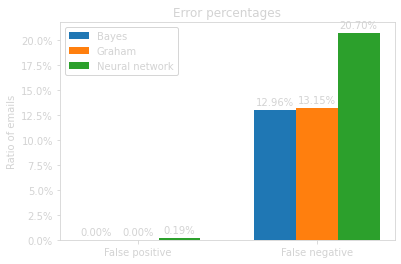

In [37]:
plot_results([results_bayes, results_graham, results_neural], ['Bayes', 'Graham', 'Neural network'])

We got $20.7\%$ false negatives, and also $0.19\%$ false positives.

But an enhancement suggests itself: we could allow more epochs. Let's set a maximum of 1000 epochs (following [Google's guide](https://developers.google.com/machine-learning/guides/text-classification/step-4)), and early stopping monitoring the convergence of false negatives (false positives are likely to converge faster, as we set a close-to-1 threshold):

In [38]:
fit_model(epochs=1000, callbacks=[tf.keras.callbacks.EarlyStopping(monitor='false_negatives', patience=2)])

Epoch 1/1000
146/146 [==============================] - 1s 6ms/step - loss: 0.1721 - false_positives: 4.0000 - false_negatives: 910.0000
Epoch 2/1000
146/146 [==============================] - 1s 6ms/step - loss: 0.1570 - false_positives: 4.0000 - false_negatives: 844.0000
Epoch 3/1000
146/146 [==============================] - 1s 6ms/step - loss: 0.1431 - false_positives: 4.0000 - false_negatives: 781.0000
Epoch 4/1000
146/146 [==============================] - 1s 6ms/step - loss: 0.1331 - false_positives: 4.0000 - false_negatives: 755.0000
Epoch 5/1000
146/146 [==============================] - 1s 6ms/step - loss: 0.1221 - false_positives: 4.0000 - false_negatives: 692.0000
Epoch 6/1000
146/146 [==============================] - 1s 6ms/step - loss: 0.1136 - false_positives: 4.0000 - false_negatives: 657.0000
Epoch 7/1000
146/146 [==============================] - 1s 5ms/step - loss: 0.1056 - false_positives: 4.0000 - false_negatives: 627.0000
Epoch 8/1000
146/146 [===================

17/17 [==============================] - 0s 4ms/step - loss: 0.0604 - false_positives: 1.0000 - false_negatives: 22.0000
{'false_positives': 1.0, 'false_negatives': 22.0}


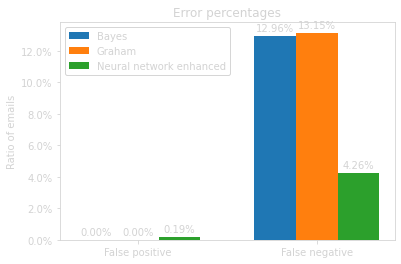

In [39]:
results_neural_enhanced = evaluate_model()
print(results_neural_enhanced)
plot_results([results_bayes, results_graham, results_neural_enhanced], ['Bayes', 'Graham', 'Neural network enhanced'])

With the enhanced neural network, we achieved an impressively low $4.26\%$ false negative rate! But there are still $0.19\%$ false positives, that is, one single email. Let's have a look at that:

In [40]:
for email, label in ds_test.unbatch():
    email_str = email.numpy().decode(encoding)
    label_int = label.numpy()
    prediction_float = model.predict([email_str])[0][0]
    if label_int == 0 and prediction_float > prob_threshold:
        print(email_str)
        print(f'Label: {label_int}')
        print(f'Prediction: {prediction_float}')

Subject: digitize your memories with compaq scanners
tired of searching for your photos or important files ?
quit looking . we have a solution . we  ' re offering a compaq tested and
approved agfa ( tm ) snapscan touch usb scanner for just $ 99 .
or for sharper photo reproduction , an epson ( tm ) perfection 1200 u
usb scanner is available for just $ 199 .
picture having all your photos on your hard drive , scanned in and
ready to e - mail to friends and family or to store in cd libraries .
you ' ll also be able to unclutter that office , allowing you to store
documents as easily as placing the original on the scanner bed
and clicking .
not only will these scanners simplify your life , but these great
values come with easy - to - use software , are usb compatible and are ready
to go a few moments out of the box .
so stop your search . everything you need is just a click away .
to order the agfa snapscan , go to
http : / / greatideas . compaq . com / cgi - bin 6 / flo ? y = ecp 20 bdtn

It's a Compaq advertisement, arguably spam. So the situation here seems more like AI has been smarter than human intelligence.

To sum up, Bayesian filters on the `Enron1` dataset proved to be better than a naive text classification neural network, but an enhanced neural network can exceed them. However, this comes at a significant computational cost: on an [AWS T2](https://aws.amazon.com/ec2/instance-types/t2/) medium instance with 2 CPUs and 4 GiB memory, even the naive neural network's training took about 10 seconds, the enhanced one's took about a half minute, whereas in the Bayesian filtering, calculating the word probabilities (the single computationally expensive part of the algorithm; comparable to training in neural networks) only required about 2 seconds.